In [28]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines, numpy as np, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
#import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import root_pandas,glob

import gc

import uproot
def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='images'

#import misc_util#correlation_plots

import R2h_module
#import imp
#imp.reload(R2h_module)

import mplhep as hep
hep.style.use("CMS")

In [29]:
def getdatainChunks(filename,treename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)[treename]

In [30]:
dfs_pair={}
for target in "D C Fe Pb".split():
    dfs_pair[target]=getdatainChunks(f"MC_pion_proton_pairs_weighted_{target}.pkl", target).copy()
def poly(a, coeffs):
    ret=0
    for i in range(len(coeffs)):
        ret=ret+coeffs[i]*a**i
    return ret
for df in dfs_pair.values():
    p=df.h2_p#eval("sqrt(h2_E**2-0.09383**2)")
    T4=df.h2_T4
    coeffs_high_range1=120.251,-1168.19,5237.42,-13638.1,22325.3,-23649.6,16177.8,-6894.16,1663.4,-173.474
    coeffs_low_range1=-26.8257,153.155,-408.979,673.476,-790.433,708.255,-474.843,217.295,-58.6269,6.90981
    coeffs_high_range2=1.59223,-1.49056,0.676338,-0.104644
    coeffs_low_range2=-1.1009,0.719988,-0.280016,0.0319352
    df['pass_proton_TOF_cut']=((p>0.2)&(p<0.8)&(T4<poly(p,coeffs_high_range1))&(T4>poly(p,coeffs_low_range1)))|\
                  ((p>=0.8)&(p<2.8)&(T4<poly(p,coeffs_high_range2))&(T4>poly(p,coeffs_low_range2))) 
    print(len(df.query('pass_proton_TOF_cut'))/len(df))

0.468277419264917
0.46402836814947834
0.46033822804529995
0.464843033284943


In [31]:
for key in dfs_pair.keys():
    dfs_pair[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_pair[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)

In [32]:
df=dfs_pair['D']
print(list(df.columns))
print(len(df))
df_accepted=df.query("pass_recon==1")

['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'e_px', 'e_py', 'e_pz', 'e_p', 'e_ph', 'e_th', 'SampFracEl25', 'SampFracEl20', 'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', 'h1_p', 'h2_p', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe', 'h1_Sector', 'h2_Sector', 'h1_FidCutPiPlus', 'h2_FidCutPiPlus', 'h1_FidCutPiPlus', 'h2_FidCutPiPlus', 'h1_Chi2CC', 'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'h1_Betta', 'h2_Betta', 'h1_T4', 'h2_T4', 'evnt', 'pass_recon', 'dphi_truth', 'dphi_lab_truth', 'drap_truth', 'h1_truth_z', 'h2_truth_z', 'h1_truth_cm_pt', 'h2_truth_cm_pt', 'h1_truth_xf', 'h2_truth_xf', 'h1_truth_rap', 'ycm_truth', 'h2_truth_rap', 'h1_truth_pid', 'h2_truth_pid', 'h1_truth_p', 'h2_truth_p', 'h1_truth_cm_ph', 'h2_truth_cm_ph', 'h1_truth_cm_th', 'h2_t

In [33]:
p_thr=2.7
#Nphe_thr=15
Nphe_thr=5
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)

trigger_cut_nom   ='h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_nom_pi_p  ='h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s'%(Nphe_h1_cut,Chi2CC_h1_cut,StatCC_h1_cut)

In [84]:
#def ratio_plot(q_num, q_denom, ylabel=None, slice_var="drap", xvar="dphi", slice_bins=(0.4, 0.6, 0.8, 1.2, 1.6, 2.0, 2.8), 
#              xbins=np.linspace(0, np.pi, 9), xlabel="$\Delta\phi$ [rad]", slice_label="\\Delta Y", slice_units=""):
def ratio_plot(q_num, q_denom, df, ylabel=None, slice_var="drap", xvar="dphi", slice_bins=np.linspace(0, 3.0,7), 
              xbins=np.linspace(0, np.pi, 9), xlabel="$\Delta\phi$ [rad]", slice_label="\\Delta Y", slice_units="", weighted=True,
              ls=None,fillstyle=None, tag=""):
    #print(q_num)
    #print(q_denom)
    #print(len(df.query(q_denom)))
    colors="tab:blue tab:orange tab:green tab:red tab:purple tab:brown".split()
    ratio=[]
    dratio=[]
    for i in range(len(slice_bins)-1):
        dfq=df.query(q_denom + f" and {slice_var}>{slice_bins[i]} and {slice_var}<{slice_bins[i+1]}")
        d,x=np.histogram(dfq.eval(xvar), bins=xbins, weights=dfq.weight_reco_2 if weighted else None)
        d_uw,x=np.histogram(dfq.eval(xvar), bins=xbins)
        dfq=df.query(q_num + f" and {slice_var}>{slice_bins[i]} and {slice_var}<{slice_bins[i+1]}")
        n,x=np.histogram(dfq.eval(xvar), bins=xbins, weights=dfq.weight_reco_2 if weighted else None)
        n_uw,x=np.histogram(dfq.eval(xvar), bins=xbins)
        
        bincenters=(x[1:]+x[:-1])/2
        ri=n/(d+(d==0))
        if not weighted:
            dri=np.sqrt((n+(n==0))*(d-n+(d-n==0))/(d+(d==0))**3)
        else :
            dri=ri/((n_uw+(n_uw==0))/(d_uw+(d_uw==0)))*np.sqrt((n_uw+(n_uw==0))*(d_uw-n_uw+(d_uw-n_uw==0))/(d_uw+(d_uw==0))**3)
        
        slc=(d>=0)
        dri=dri*(d!=0)+.002*(d==0)
        label=f"${slice_bins[i]:.1f}<{slice_label}<{slice_bins[i+1]:.1f}$ {slice_units}"
        if slice_bins[i]==0.35:
            label=label.replace("0.3", "0.35")
        plt.errorbar((bincenters+i*.01)[slc], ri[slc], dri[slc], 
                     label=label+tag,
                    marker="o", linestyle=ls, fillstyle=fillstyle, color=colors[i])
        ratio.append(ri)
        dratio.append(dri)
    plt.xlabel(xlabel)
    
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.ylim(0,1)
    plt.legend()
    return ratio, dratio

(array([ 711.,  663.,  714.,  767.,  767.,  793.,  924.,  949.,  967.,
         935., 1011., 1099., 1159., 1214., 1233., 1263., 1293., 1397.,
        1373., 1360., 1457., 1559., 1600., 1582., 1580., 1695., 1622.,
        1668., 1695., 1641., 1749., 1791., 1721., 1710., 1768., 1772.,
        1777., 1810., 1806., 1850., 1851., 1930., 1937., 1864., 1821.,
        1757., 1608., 1549., 1399., 1386., 1359., 1552., 1729., 1683.,
        1828., 1942., 1958., 1903., 1842., 1817., 1899., 1874., 1815.,
        1748., 1715., 1676., 1677., 1715., 1730., 1675., 1684., 1712.,
        1724., 1575., 1611., 1655., 1568., 1568., 1491., 1535., 1443.,
        1424., 1395., 1353., 1161., 1166., 1154., 1111., 1146., 1060.,
         996.,  950.,  911.,  879.,  845.,  768.,  712.,  724.,  755.,
         734.]),
 array([-3.14159265e+00, -3.07876080e+00, -3.01592895e+00, -2.95309709e+00,
        -2.89026524e+00, -2.82743339e+00, -2.76460154e+00, -2.70176968e+00,
        -2.63893783e+00, -2.57610598e+00, -2.51327

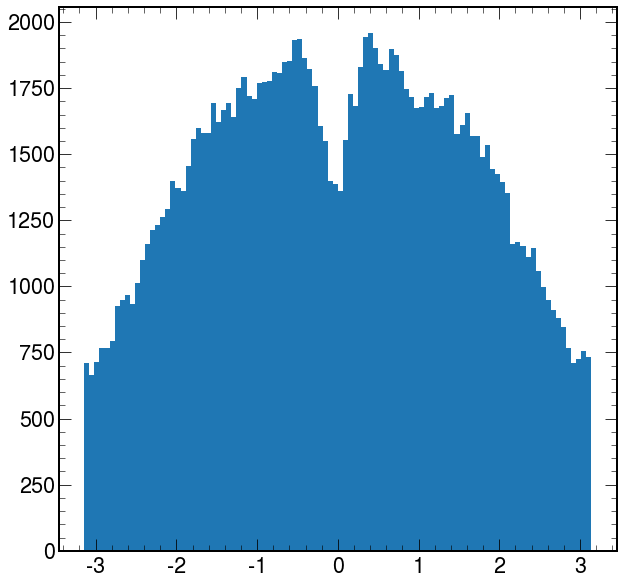

In [43]:
q_denom="h1_p!=0"#h1_p>0 and e_p>0 and h1_pid==211 and h1_truth_pid==211 and h1_FidCutPiPlus and nu>2.3 and nu<4.2 and Q2>1 "
#q_denom+=" and h1_cm_pt>0.07 and h2_truth_cm_pt>0.07 and h1_z>0.5 and h2_truth_pid==2212 and h2_truth_p>0.35 and h2_truth_p<2.8 and h2_truth_th>10"
#q_denom+= " and abs(h1_p-h1_truth_p)/h1_truth_p<0.3"
#q_denom+= " and " + trigger_cut_nom

plt.hist(dfs_pair['D'].query(q_denom).h2_truth_cm_ph, bins=100, range=(-np.pi, np.pi))

In [44]:
df['h2_p']=np.where(df.h2_p< 100, df.h2_p, -9999)
df['h1_p']=np.where(df.h2_p< 100, df.h2_p, -9999)

target= D variation= 0.043643371660504304
(max-min)/(max+min)*2= 0.14858617130581375


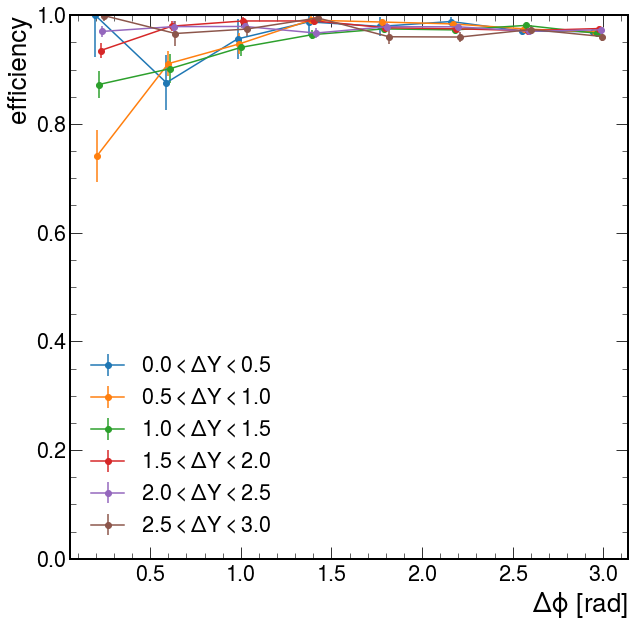

target= C variation= 0.03236782247763759
(max-min)/(max+min)*2= 0.0864162237580929


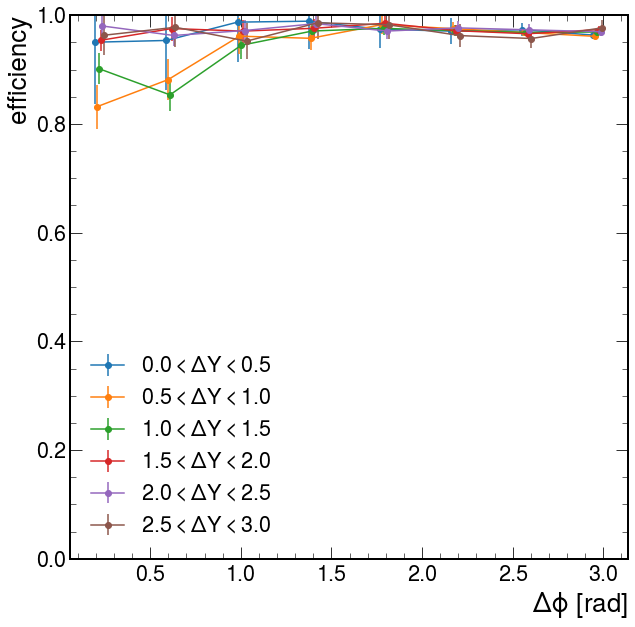

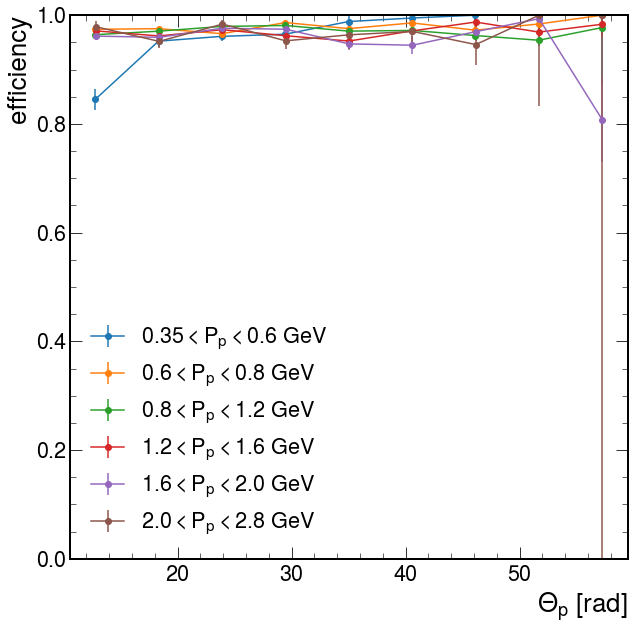

In [94]:
#First look at the efficiency of detecting a single particle

q_denom="h1_p>0"
q_denom+=" and e_p>0"
q_denom+= " and h1_pid==211 and h1_truth_pid==211 and nu>2.3 and nu<4.2 and Q2>1 "
q_denom+=" and h1_FidCutPiPlus == 1"
q_denom+=" and h1_cm_pt>0.07 and h2_truth_cm_pt>0.07 and h1_z>0.5 and h2_truth_pid==2212 and h2_truth_p>0.35 and h2_truth_p<2.8 and h2_truth_th>10"

q_denom+= " and " + trigger_cut_nom
q_num=q_denom

q_num+=" and pass_proton_TOF_cut "
q_num+=" and h2_pid==2212"
q_num+=" and h2_FidCutPiPlus == 1"
q_num+=" and " + pair_cut_nom_pi_p 

efficiencies_2d, defficiencies_2d={},{}
for target in "D C".split():
    eff,deff = ratio_plot(q_num, q_denom, dfs_pair[target],  
                                                                   ylabel="efficiency", slice_var="drap_truth",
                                                   slice_bins=(0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0),xvar="dphi_truth")
    efficiencies_2d[target]=eff
    defficiencies_2d[target]=deff
    import awkward as ak
    vals=ak.flatten(efficiencies_2d[target])
    print("target=",target,"variation=",np.std(vals)/np.mean(vals))
    print("(max-min)/(max+min)*2=", (np.max(vals)-np.min(vals))/(np.max(vals)+np.min(vals)))
    
    #plt.title(f"proton efficiency: {target}")
    #plt.title("$p^T_{p,\pi^+}>0.25$ GeV")
    plt.savefig(f"images/efficiency_proton_{target}.pdf")
    #plt.title("weighted")
    
    plt.show()

# ratio_plot(q_num, q_denom, dfs_pair['D'], ylabel="efficiency", slice_var="drap_truth-ycm_truth",
#                                                slice_bins=(-1.0, -0.5,0, 0.5, 1.0, 1.5, 2.0),xvar="dphi_truth", weighted=False)
# plt.title("unweighted")
# plt.show()

ratio_plot(q_num, q_denom, dfs_pair['D'], ylabel="efficiency", 
                                               slice_var="h2_truth_p", xvar="h2_truth_th", xlabel="$\\Theta_p$ [rad]",
                                              xbins=np.linspace(10, 60, 10),
                                               slice_bins=(0.35, 0.6, 0.8, 1.2, 1.6, 2.0, 2.8), slice_units="GeV",
                                              slice_label='P_p', weighted=True)

#plt.title("$p^T_{p,\pi^+}>0.25$ GeV")
plt.savefig(f"images/efficiency_proton_p_theta.pdf")
plt.show()

In [46]:
import pickle
with open("pion_proton_efficiencies.pkl", "wb") as f:
    pickle.dump({"eff2d":efficiencies_2d['D'], "deff2d":defficiencies_2d['D']},f)#,"eff1d":efficiencies_1d, "deff1d":defficiencies_1d}, f)

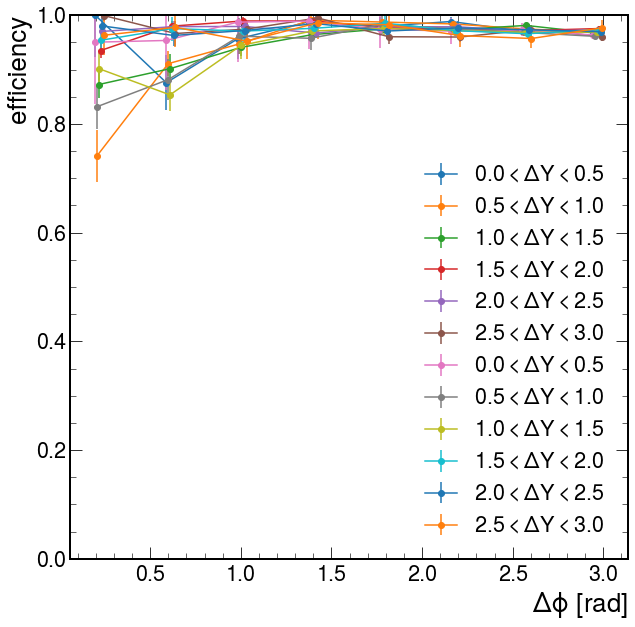

0.5127232289248113


In [47]:
eff,deff={},{}

for i in range(2):
    target="DC"[i]
    ls="- --".split()[i]
    eff[target],deff[target] = ratio_plot(q_num, q_denom, dfs_pair[target],  
                                                                   ylabel="efficiency", slice_var="drap_truth",
                                                   slice_bins=(0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0),xvar="dphi_truth", weighted=True)
plt.show()
chi2=0
for i in range(6):
    chi2+=np.sum((eff['C'][i]-np.array(eff['D'][i]))**2/(np.array(deff['C'][i])**2+np.array(deff['D'][i])**2))
    
print(chi2/48)
plt.show()

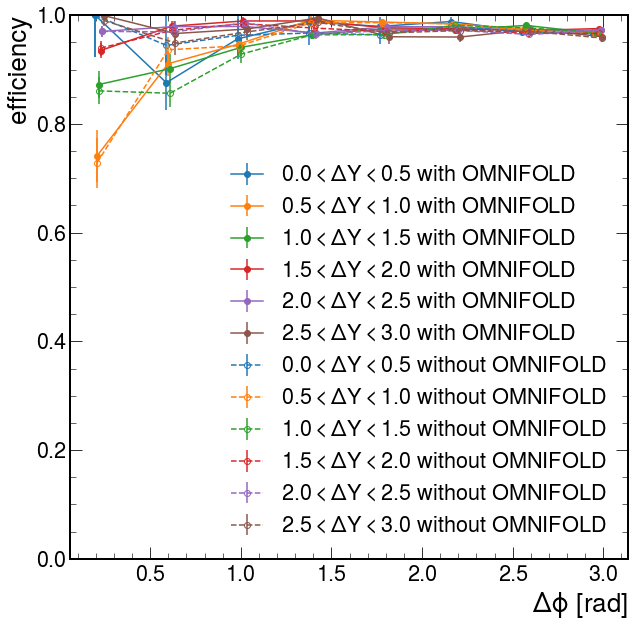

0.5206908538590734


In [90]:
q_denom="h1_p>0"
q_denom+=" and e_p>0"
q_denom+= " and h1_pid==211 and h1_truth_pid==211 and nu>2.3 and nu<4.2 and Q2>1 "
q_denom+=" and h1_FidCutPiPlus == 1"
q_denom+=" and h1_cm_pt>0.07 and h2_truth_cm_pt>0.07 and h1_z>0.5 and h2_truth_pid==2212 and h2_truth_p>0.35 and h2_truth_p<2.8 and h2_truth_th>10"

q_denom+= " and " + trigger_cut_nom
q_num=q_denom

q_num+=" and pass_proton_TOF_cut "
q_num+=" and h2_pid==2212"
q_num+=" and h2_FidCutPiPlus == 1"
q_num+=" and " + pair_cut_nom_pi_p 

eff,deff={},{}

for i in range(2):
    target="D"
    weighted=1-i
    ls="- --".split()
    eff[weighted],deff[weighted] = ratio_plot(q_num, q_denom, dfs_pair[target],  
                                                                   ylabel="efficiency", slice_var="drap_truth",
                                                   slice_bins=(0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0),xvar="dphi_truth", weighted=weighted,
                                         tag="with OMNIFOLD" if weighted else "without OMNIFOLD",
                                         ls="-" if weighted else "--",
                                         fillstyle="full" if weighted else "none")


plt.savefig("images/with_without_omnifold.pdf")
plt.show()
chi2=0
for i in range(6):
    chi2+=np.sum((eff[1][i]-np.array(eff[0][i]))**2/(np.array(deff[1][i])**2+np.array(deff[0][i])**2))
    
print(chi2/48)

In [49]:
ptmin=0.07#0.07
q="h1_p>0 and e_p>0 and h1_pid==211"
q+=f" and h1_cm_pt>{ptmin} and h2_cm_pt>{ptmin} and h1_z>0.5 and pass_proton_TOF_cut and h2_pid==2212 and h2_p>0.35 and h2_p<2.8 and h2_truth_th>10"
q+=" and h2_FidCutPiPlus==1 and h1_FidCutPiPlus==1 and h1_truth_pid!=-9999 and h2_truth_pid!=-9999"
q+=" and h2_truth_p>0"

ecorr_pars={"C":[0.00205, 0.000217, 0.0913],
    "Fe": [0.00205, 0.000218, 0.0911],
    "Pb": [0.00205, 0.000218, 0.0912],
    "D": [0.00208, 0.000255, 0.0886]}

dfs_pair["D"].eval(f"h2_p_corr=sqrt((sqrt(h2_p**2+.9383**2)+{ecorr_pars['D'][0]}+{ecorr_pars['D'][1]}/({ecorr_pars['D'][2]}+h2_p)**2)**2-.9383**2)", inplace=True)
dfs_pair["D"].eval("h2_cm_pt_corr=h2_p_corr/h2_p*h2_cm_pt", inplace=True)

df.eval("h2_rap_corr=(h2_rap+ycm)/abs(h2_rap+ycm)*0.5*log((sqrt(h2_p_corr**2+.9383**2)+sqrt(h2_p_corr**2-h2_cm_pt_corr**2))/"\
        +"(sqrt(h2_p_corr**2+.9383**2)-sqrt(h2_p_corr**2-h2_cm_pt_corr**2)))-ycm",inplace=True)
df.eval("drap_corr=drap+h2_rap-h2_rap_corr", inplace=True)
q_corr=q.replace("h2_p>", "h2_p_corr>").replace("h2_cm_pt", "h2_cm_pt_corr")

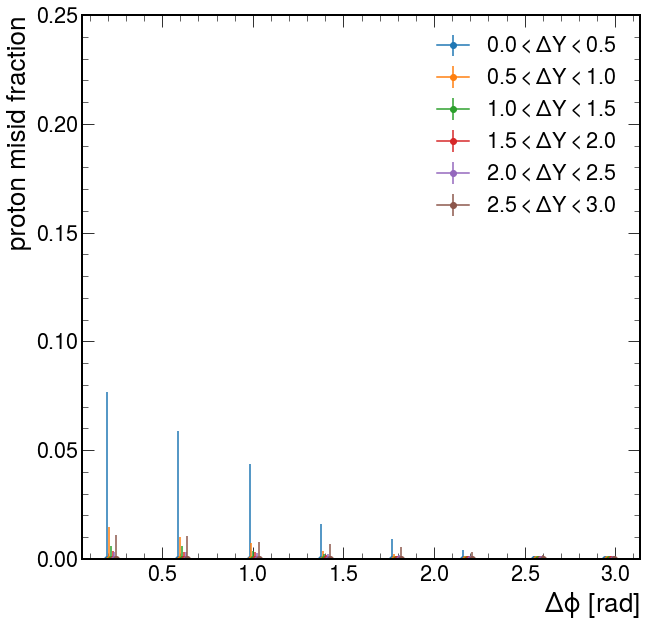

weighted average= 0.03702895385303047


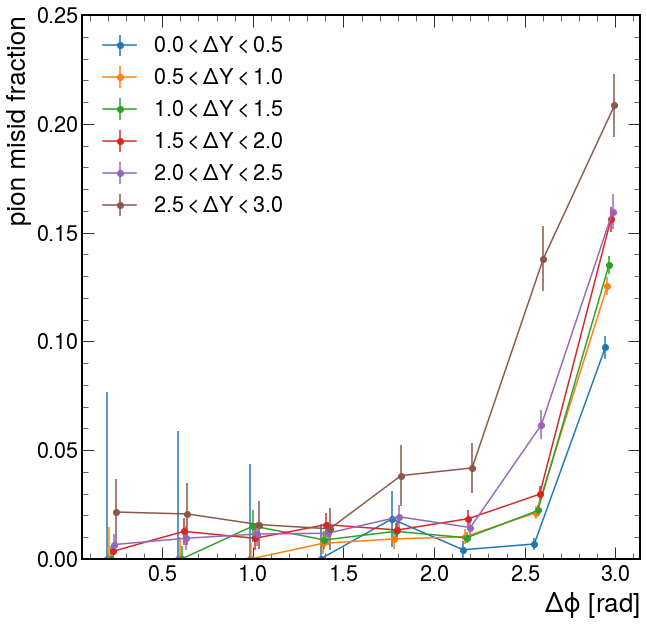

In [69]:
#now check the purity of the sample
for misid_particle in "proton", "pion":

    q_denom="h1_p>0 and e_p>0 and h1_pid==211"
    q_denom+=" and h1_cm_pt>0.07 and h2_cm_pt_corr>0.07 and h1_z>0.5 and pass_proton_TOF_cut and h2_pid==2212 and h2_p_corr>0.35 and h2_p_corr<2.8 and h2_truth_th>10"
    q_denom+=" and h2_FidCutPiPlus==1 and h1_FidCutPiPlus ==1"
    q_denom+=" and h1_truth_pid!=-9999 and h2_truth_pid!=-9999"
    #q_denom+=" and abs(h1_truth_th-h1_th)<0.006*180/3.14159"
    #q_denom+=" and abs(h1_truth_ph-h1_ph)<0.012*180/3.14159"
#    q_denom+= " and 
    q_denom+= " and " + trigger_cut_nom
    q_denom+=" and " + pair_cut_nom_pi_p 
    if misid_particle =="proton":
        q_num=q_denom+" and (h2_truth_pid!=2212)"
    else :
        q_num=q_denom+" and (h1_truth_pid!=211)"

    #print({id: len(dfs_pair['D'].query(q_num + f" and h1_truth_pid=={id}")) \
    #                   for id in set(dfs_pair['D'].query(q_num)["h1_truth_pid"])})
    
    misids,dmisids=ratio_plot(q_num, q_denom,dfs_pair['D'], ylabel=misid_particle+" misid fraction",slice_var="drap_corr",  
                              slice_bins=(0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0), weighted=False)
    if misid_particle=="pion":
        misid_avg=sum(dfs_pair['D'].query(q_num).weight_reco)/len(dfs_pair['D'].query(q_denom).weight_reco)
        print("weighted average=", misid_avg)
    #print(misids)
    #print(dmisids)
    #plt.title("$p^T_{p,\pi^+}>0.25$ GeV")
    plt.ylim(0,.25)
    plt.savefig(f"images/misid_{misid_particle}.pdf")
    plt.show()

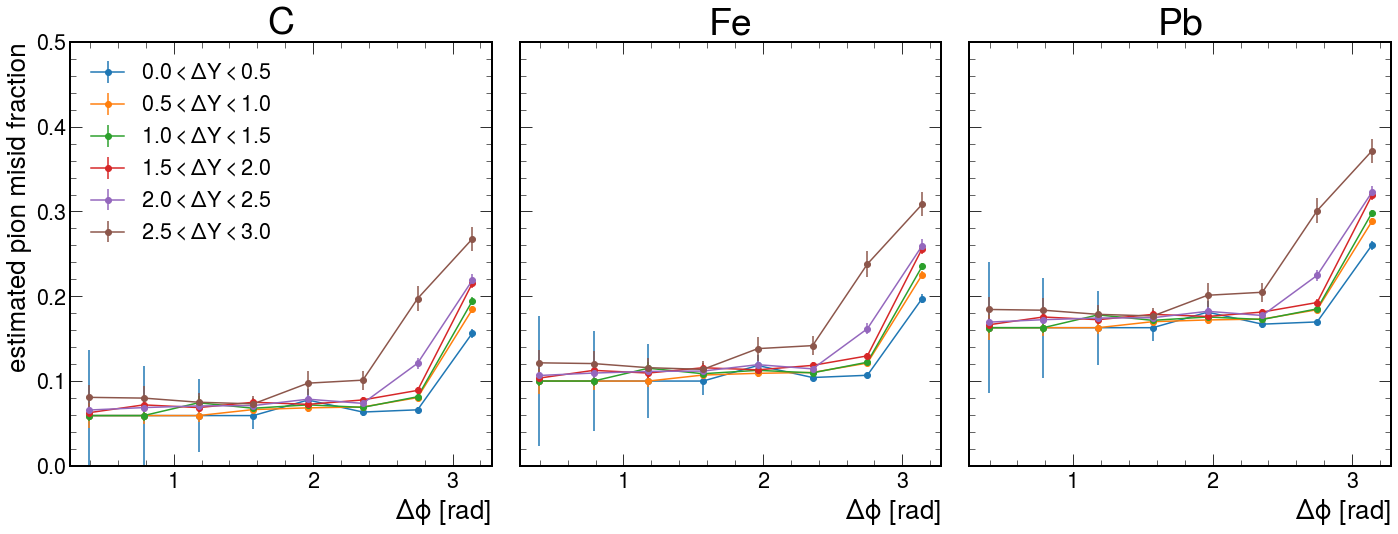

In [79]:
fig, axs=plt.subplots(1,3, figsize=(20, 8), sharey='all')
for j,(A, S) in enumerate((("C",2.6), ("Fe",3.7), ("Pb",5.4))):
    x=np.pi/8+np.linspace(0, np.pi*7/8, 8)
    plt.sca(axs[j])
    for i in range(6):
        plt.errorbar(x, misids[i]+misid_avg*(S-1), dmisids[i], label=f"${i*0.5}<\\Delta Y< {(i+1)*0.5}$", marker='o')
    plt.title(A)
    plt.xlabel("$\Delta\phi$ [rad]")
    
    if j==0:
        plt.ylabel("estimated pion misid fraction")
        plt.legend();
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig(f"images/misid_pion_nuclear.pdf")
        
    
#    plt.plot(misids[i]

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.37846833e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.91627027e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.40967312e-01, 1.28946004e-01, 0.00000000e+00,
        6.09853059e-01, 0.00000000e+00, 5.07215212e-01, 0.00000000e+00,
        1.56957905e-01, 6.73850320e-01, 9.76255668e-03, 5.81074900e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 7.72445580e-01, 7.85349519e-01,
        1.01005239e-01, 0.00000000e+00, 1.57473635e-01, 4.10332282e-01,
        1.03566403e+00, 1.37470909e+00, 4.98309038e-01, 2.90455254e+00,
        2.78491887e+00, 5.28796026e+00, 6.39454312e-01, 3.42724357e+00,
        2.75455386e+00, 2.42766916e+00, 5.85427658e+00, 9.377497

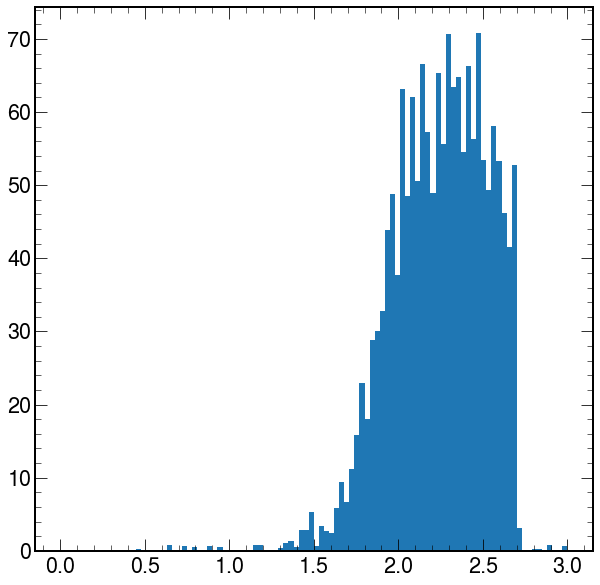

In [634]:
plt.hist(dfs_pair['D'].query("h1_truth_pid==321 and h2_truth_pid==2212 and h1_cm_pt>0 and h2_cm_pt>0").eval("h"), range=(0,3),bins=100, 
         weights=dfs_pair['D'].query("h1_truth_pid==321 and h2_truth_pid==2212").eval('weight_reco'))

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   5.,   4.,   2.,
          5.,   1.,   7.,  11.,  11.,  10.,  17.,  12.,  15.,  22.,  28.,
         21.,  34.,  45.,  35.,  48.,  60.,  68.,  90., 101.,  97., 129.,
        157., 170., 167., 214., 247., 286., 291., 329., 385., 424., 425.,
        455., 551., 543., 615., 629., 678., 725., 757., 741., 771., 818.,
        802., 781., 828., 844., 872., 790., 834., 839., 802., 844., 810.,
        794., 803., 794., 769., 793., 703., 689., 678., 618., 535., 448.,
        385., 317., 224., 171., 109.,  78.,  39.,  23.,   7.,   8.,   4.,
          5.]),
 array([-1.55139046, -1.51438224, -1.47737403, -1.44036581, -1.4033576 ,
        -1.36634938, -1.32934117, -1.29233295, -1.25532474, -1.21831652,
        -1.18130831, -1.1443001 , -1.10729188, -1.07028367, -1.03327545,
        -0.99626724, -0.95925902, -0.92225081, -0.88524259, -0.84823438,
        -0.81122617, -0.77

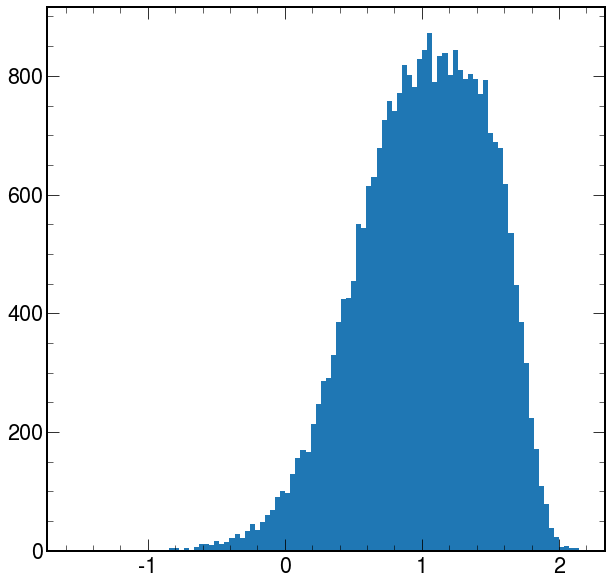

In [598]:
plt.hist(dfs_pair['D'].query("h1_truth_pid==321 and h2_truth_pid==2212 and h1_cm_pt>0 and nu>2.3 and nu<4.2 and Q2>1").eval("drap_truth"),bins=100)

In [77]:
with open('pion_proton_misid.pkl', "wb") as f:
    pickle.dump(misids,f)


h1_z>0.5 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus>0 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_z>0.5 and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus>0 and h2_FidCutPiPlus>0 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*n

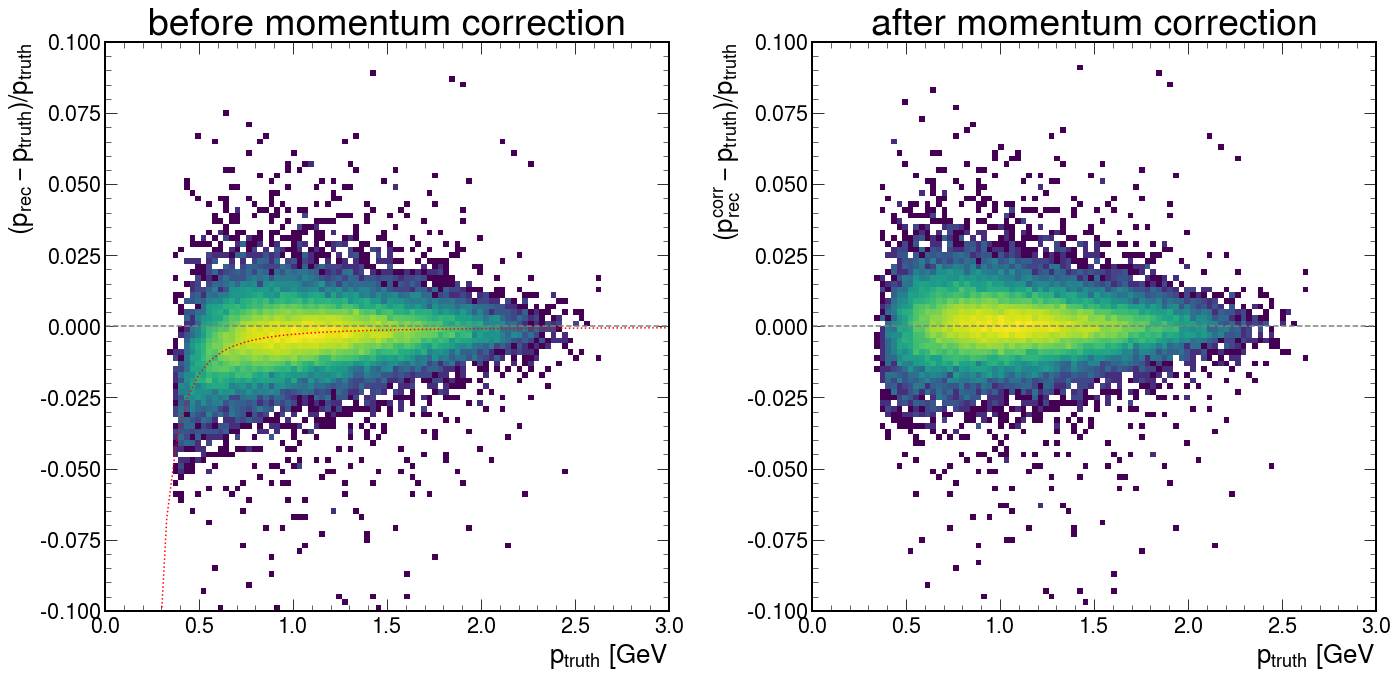

In [625]:
q=trigger_cut_nom+" and " + pair_cut_nom_pi_p+\
    " and h1_z>0.5 and h1_pid==211 and h1_truth_pid==211 and h1_FidCutPiPlus==1 and nu>2.3 and nu<4.2 and Q2>1 and h2_pid==2212"\
    + " and h2_p>0.35 and h2_cm_pt>0.07 and h1_cm_pt>0.07 and h2_FidCutPiPlus==1 and drap_corr-ycm>-1.0 and drap_corr-ycm<2.0"\
     " and abs(h2_truth_th-h2_th)<30 and h1_truth_pid!=-9999 and h2_truth_pid!=-9999"

q=q.replace("FidCutPiPlus==1", "FidCutPiPlus>0")
print(q)
fig, axs=plt.subplots(1,2, figsize=(20,10),sharex='all')
plt.sca(axs[0])
plt.hist2d(dfs_pair["D"].query(q).eval("h2_truth_p"), dfs_pair["D"].query(q).eval("(h2_p-h2_truth_p)/h2_truth_p"), 
           range=((0, 3), (-0.1,0.1)), bins=100, norm=matplotlib.colors.LogNorm(), weights=None)
plt.xlabel("$p_{truth}$ [GeV")
plt.ylabel("$(p_{rec}-p_{truth})/p_{truth}$")
plt.title("before momentum correction")
plt.axhline(0, color='0.5', ls='--')
h2_p=np.linspace(0, 3)
h2_p_corr=np.sqrt((np.sqrt(h2_p**2+.9383**2)+0.0013+0.00084/(.074+h2_p)**2)**2-.9383**2)
plt.plot(h2_p_corr, (h2_p-h2_p_corr)/h2_p_corr, color='r', ls=':')
plt.sca(axs[1])


q_corr=q.replace("h2_p>", "h2_p_corr>").replace("h2_cm_pt", "h2_cm_pt_corr")
plt.hist2d(dfs_pair["D"].query(q_corr).eval("h2_truth_p"), dfs_pair["D"].query(q_corr).eval("(h2_p_corr-h2_truth_p)/h2_truth_p"), 
           range=((0, 3), (-0.1,0.1)), bins=100, norm=matplotlib.colors.LogNorm(), weights=None)
plt.axhline(0, color='0.5', ls='--')
plt.xlabel("$p_{truth}$ [GeV")
plt.ylabel("$(p^{corr}_{rec}-p_{truth})/p_{truth}$")
plt.title("after momentum correction")
plt.tight_layout()
plt.savefig('images/p_corr.pdf')
plt.show()

0.0016353779291186882
0.04824480654477798
0.00017921949908150008
0.023353757379036198


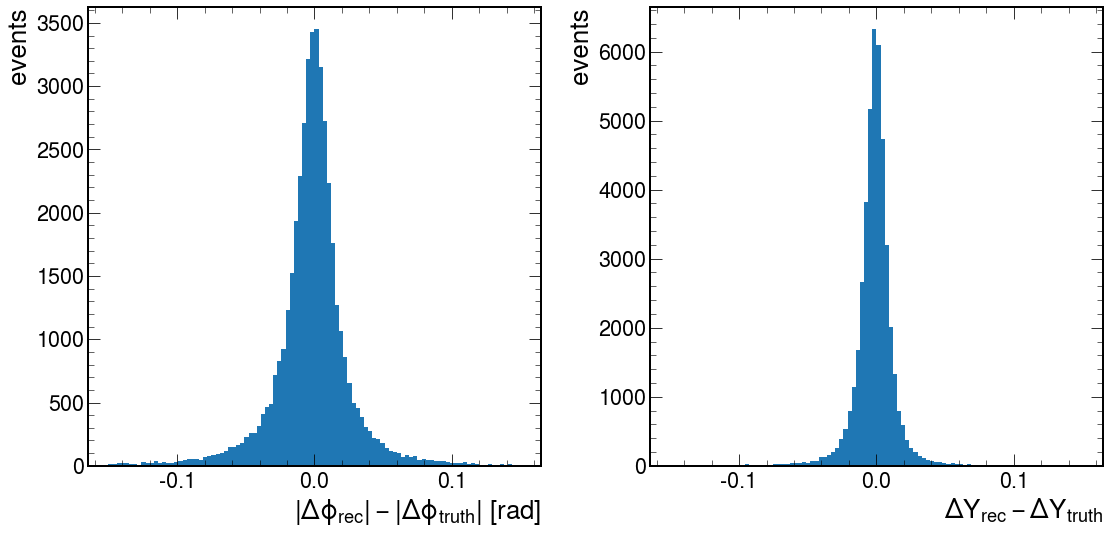

In [62]:
q=trigger_cut_nom+" and " + pair_cut_nom_pi_p +\
    " and h1_z>0.5 and h1_pid==211 and h1_truth_pid==211 and h1_FidCutPiPlus==1 and nu>2.3 and nu<4.2 and Q2>1 and h2_pid==2212"\
    + " and h2_p_corr>0.35 and h2_cm_pt_corr>0.07 and h1_cm_pt>0.07 and h2_FidCutPiPlus==1 and drap_corr>0.0 and drap_corr<3.0"\
    + " and abs(h2_truth_th-h2_th)<30  and abs(h1_truth_th-h1_th)<30"

fig, axs=plt.subplots(1,2, figsize=(16,8))
#q+=f" and drap_corr-ycm >{1.5} and drap_corr-ycm <{2.0}"
df=dfs_pair['D'].query(q)
plt.sca(axs[0])
a=df.dphi-df.dphi_truth
print(np.mean(1*(np.abs(a)>np.pi/8)))
print(np.std(a[np.abs(a)<15]))
plt.hist(a, bins=100, range=(-0.15, 0.15))
plt.xlabel("$|\\Delta\\phi_{\\rm rec}|-|\\Delta\\phi_{\\rm truth}|$ [rad]")
plt.ylabel("events")
plt.sca(axs[1])
a=df.drap_corr-df.drap_truth

print(np.mean(1*(np.abs(a)>0.5)))
print(np.std(a[np.abs(a)<15]))
plt.hist(a, bins=100, range=(-0.15,0.15))
plt.xlabel("$\\Delta Y_{\\rm rec}-\\Delta Y_{\\rm truth}$")
plt.ylabel("events")
plt.tight_layout()
plt.savefig("images/pion_proton_resolutions.pdf")
plt.show()

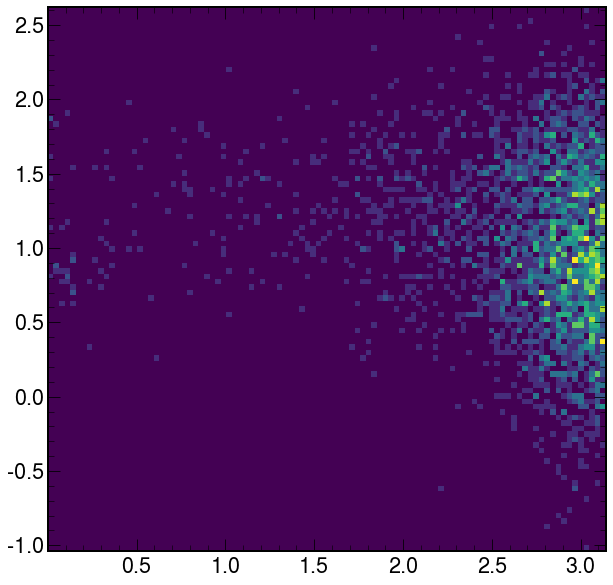

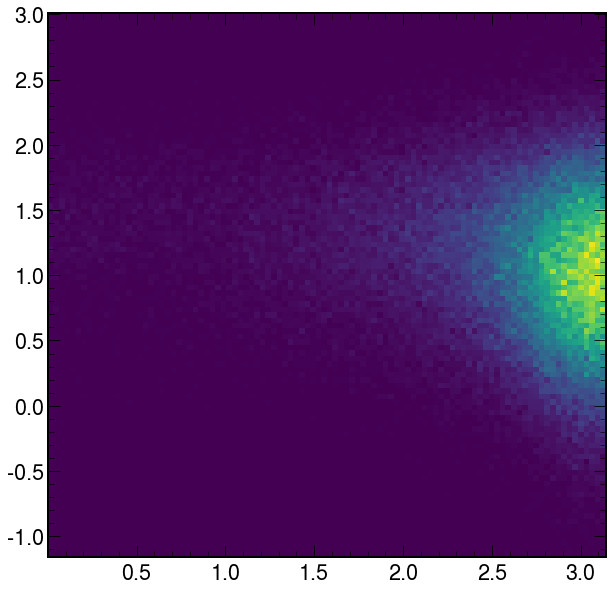

In [288]:
dfq=df.query(q_denom +" and not("+q_num+")")
plt.hist2d(dfq.dphi_truth, dfq.drap_truth, bins =100)
plt.show()
dfq=df.query(q_num)
plt.hist2d(dfq.dphi_truth, dfq.drap_truth, bins =100)
plt.show()

(array([1.08e+02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.88e+02, 4.50e+01, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 8.13e+03, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

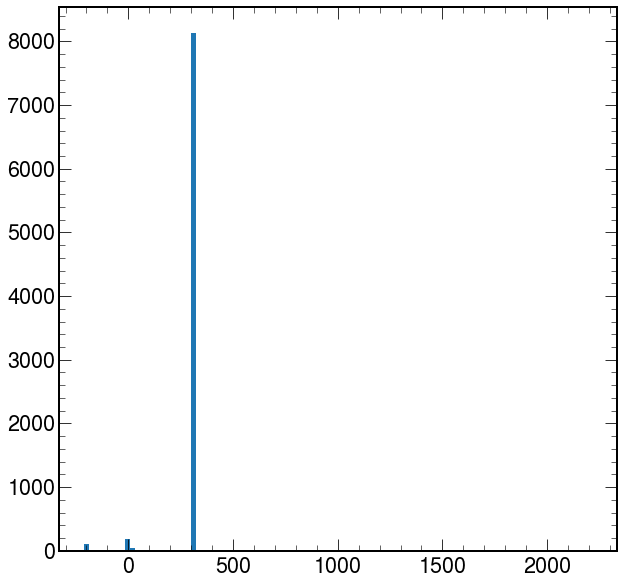

In [242]:
plt.hist(df.query(q_denom +" and h1_truth_pid!=211 and h1_truth_pid>-9999").h1_truth_pid, bins =100)

# Other plots

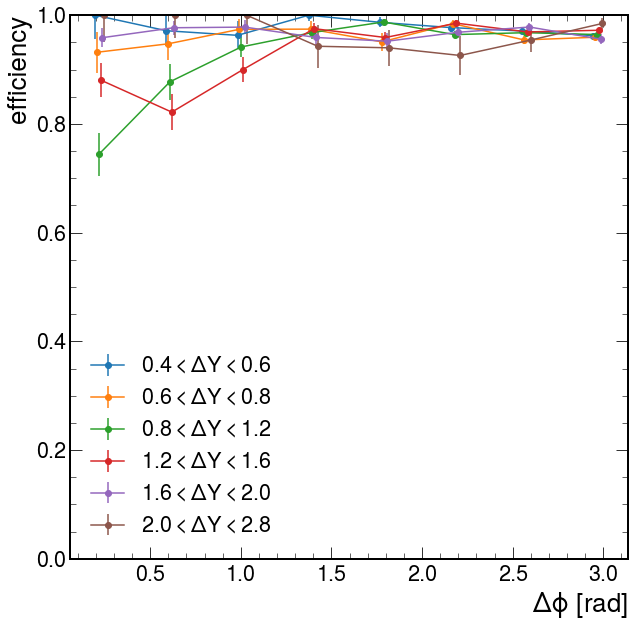

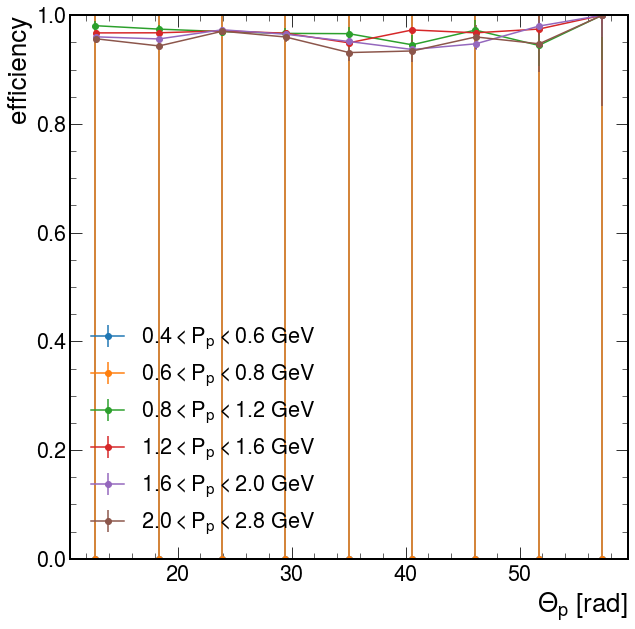

In [320]:
#First look at the efficiency of detecting a single particle

for minPt in 0.07,:
    
    q_denom="h1_p>0 and e_p>0 and h1_pid==211 and h1_truth_pid==211 and h1_FidCutPiPlus and nu>2.3 and nu<4.2 and Q2>1 "
    q_denom+=f" and h1_cm_pt>{minPt} and h2_truth_cm_pt>{minPt} and h1_z>0.5 and h2_truth_pid==2212 and h2_truth_p>0.4 and h2_truth_p<2.8 and h2_truth_th>10"
    q_denom+= " and abs(h1_p-h1_truth_p)/h1_truth_p<0.3"
    q_denom+= " and " + trigger_cut_nom
    q_num=q_denom+" and pass_proton_TOF_cut and h2_pid==2212 and h2_FidCutPiPlus and abs(h2_p-h2_truth_p)/h2_truth_p<0.3"
    q_num+=" and " + pair_cut_nom_pi_p 
    
    efficiencies_2d, defficiencies_2d = ratio_plot(q_num, q_denom, ylabel="efficiency", slice_var="drap_truth", xvar="dphi_truth")
    #plt.title("$p^T_{p,\pi^+}>0.25$ GeV")
    plt.show()
    
    efficiencies_2d, defficiencies_2d = ratio_plot(q_num, q_denom, ylabel="efficiency", 
                                               slice_var="h2_truth_p", xvar="h2_truth_th", xlabel="$\\Theta_p$ [rad]",
                                              xbins=np.linspace(10, 60, 10),
                                               slice_bins=(0.4, 0.6, 0.8, 1.2, 1.6, 2.0, 2.8), slice_units="GeV",
                                              slice_label='P_p')

    plt.show()

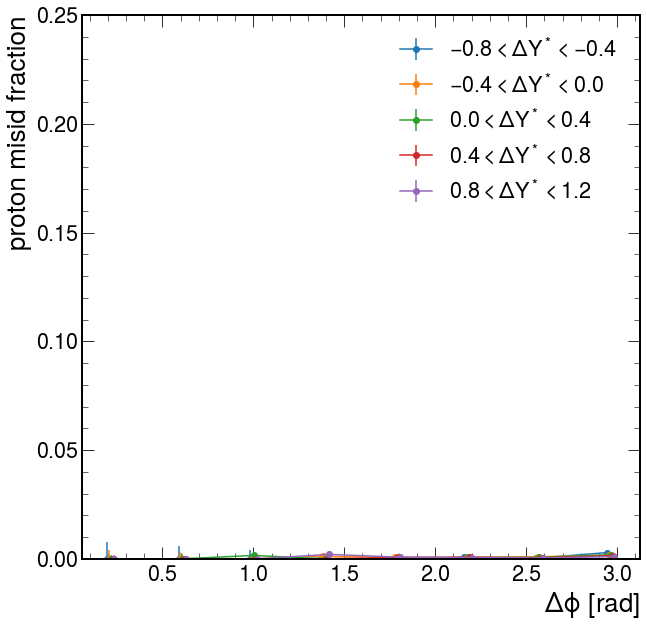

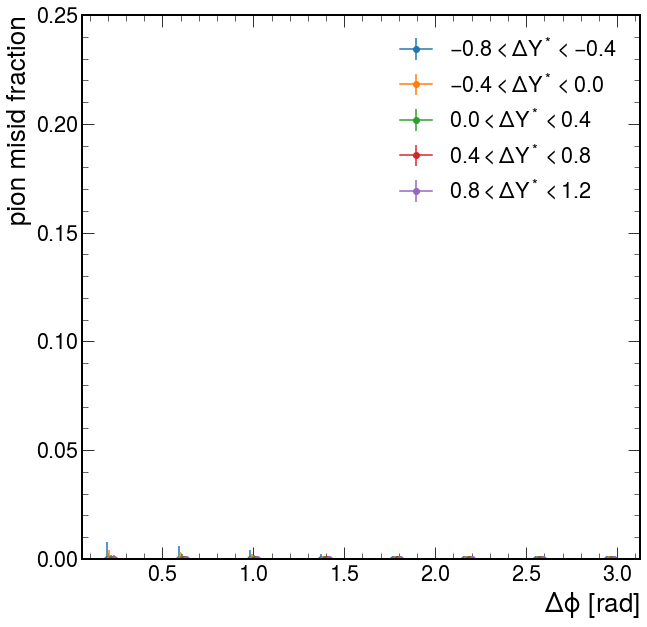

In [111]:
#now check the purity of the sample
ptmin=0.07
for misid_particle in "proton", "pion":

    q_denom="h1_p>0 and e_p>0 and h1_pid==211"
    q_denom+=f" and h1_cm_pt>{ptmin} and h2_cm_pt>{ptmin} and h1_z>0.5 and pass_proton_TOF_cut and h2_pid==2212 and h2_p>0.4 and h2_p<2.8 and h2_truth_th>10"
    q_denom+=" and h2_FidCutPiPlus and h1_FidCutPiPlus and h1_truth_pid!=-9999 and h2_truth_pid!=-9999"
    q_denom+= " and " + trigger_cut_nom
    q_denom+=" and " + pair_cut_nom_pi_p 
    if misid_particle =="proton":
        q_num=q_denom+" and (h2_truth_pid!=2212)"
    else :
        q_num=q_denom+" and (h1_truth_pid!=211)"
    
    ratio_plot(q_num, q_denom, ylabel=misid_particle+" misid fraction")
    #plt.title("$p^T_{p,\pi^+}>0.25$ GeV")
    plt.ylim(0,.25)
    #plt.savefig(f"images/misid_{misid_particle}.pdf")
    plt.show()

(array([7.740e+02, 1.425e+03, 1.731e+03, 1.951e+03, 2.117e+03, 2.372e+03,
        2.739e+03, 3.051e+03, 3.345e+03, 3.790e+03, 4.150e+03, 4.515e+03,
        4.702e+03, 4.698e+03, 4.896e+03, 4.829e+03, 4.893e+03, 4.939e+03,
        4.774e+03, 4.668e+03, 4.568e+03, 4.507e+03, 4.322e+03, 4.261e+03,
        3.941e+03, 3.806e+03, 3.791e+03, 3.494e+03, 3.434e+03, 3.255e+03,
        3.053e+03, 2.785e+03, 2.692e+03, 2.589e+03, 2.339e+03, 2.203e+03,
        1.951e+03, 1.950e+03, 1.757e+03, 1.670e+03, 1.501e+03, 1.387e+03,
        1.317e+03, 1.163e+03, 1.131e+03, 1.024e+03, 9.460e+02, 8.660e+02,
        7.750e+02, 6.990e+02, 6.240e+02, 5.850e+02, 4.770e+02, 4.720e+02,
        3.950e+02, 3.420e+02, 3.340e+02, 2.970e+02, 2.370e+02, 2.500e+02,
        2.120e+02, 1.950e+02, 1.840e+02, 1.570e+02, 1.170e+02, 1.060e+02,
        1.030e+02, 9.600e+01, 7.500e+01, 6.800e+01, 5.100e+01, 4.600e+01,
        6.100e+01, 5.000e+01, 3.600e+01, 3.200e+01, 2.100e+01, 2.600e+01,
        2.200e+01, 2.300e+01, 1.500e+0

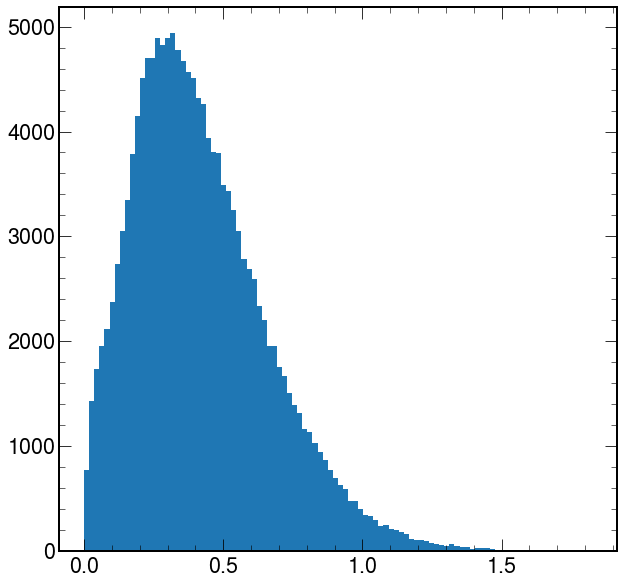

In [316]:
q="h1_z>0.5 and h1_pid==211 and h1_truth_pid==211 and h1_FidCutPiPlus and nu>2.3 and nu<4.2 and Q2>1 and h2_pid==2212"
plt.hist(df.query(q).h2_cm_pt, bins=100)

(array([7.740e+02, 1.425e+03, 1.731e+03, 1.951e+03, 2.117e+03, 2.372e+03,
        2.739e+03, 3.051e+03, 3.345e+03, 3.790e+03, 4.150e+03, 4.515e+03,
        4.702e+03, 4.698e+03, 4.896e+03, 4.829e+03, 4.893e+03, 4.939e+03,
        4.774e+03, 4.668e+03, 4.568e+03, 4.507e+03, 4.322e+03, 4.261e+03,
        3.941e+03, 3.806e+03, 3.791e+03, 3.494e+03, 3.434e+03, 3.255e+03,
        3.053e+03, 2.785e+03, 2.692e+03, 2.589e+03, 2.339e+03, 2.203e+03,
        1.951e+03, 1.950e+03, 1.757e+03, 1.670e+03, 1.501e+03, 1.387e+03,
        1.317e+03, 1.163e+03, 1.131e+03, 1.024e+03, 9.460e+02, 8.660e+02,
        7.750e+02, 6.990e+02, 6.240e+02, 5.850e+02, 4.770e+02, 4.720e+02,
        3.950e+02, 3.420e+02, 3.340e+02, 2.970e+02, 2.370e+02, 2.500e+02,
        2.120e+02, 1.950e+02, 1.840e+02, 1.570e+02, 1.170e+02, 1.060e+02,
        1.030e+02, 9.600e+01, 7.500e+01, 6.800e+01, 5.100e+01, 4.600e+01,
        6.100e+01, 5.000e+01, 3.600e+01, 3.200e+01, 2.100e+01, 2.600e+01,
        2.200e+01, 2.300e+01, 1.500e+0

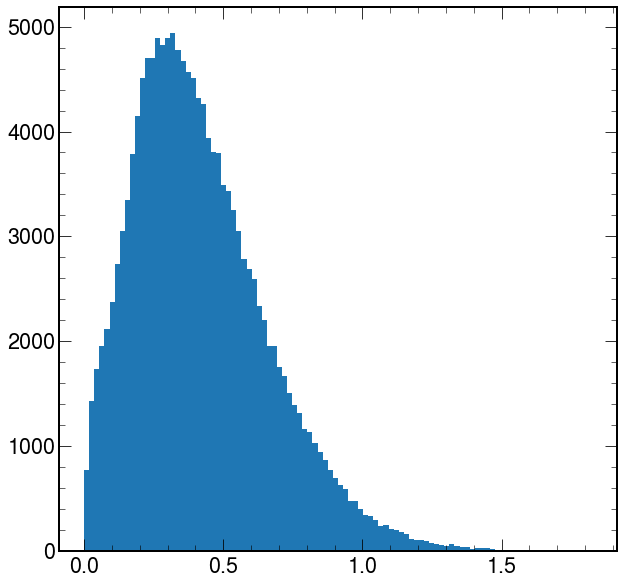

In [316]:
q="h1_z>0.5 and h1_pid==211 and h1_truth_pid==211 and h1_FidCutPiPlus and nu>2.3 and nu<4.2 and Q2>1 and h2_pid==2212"
plt.hist(df.query(q).h2_cm_pt, bins=100)

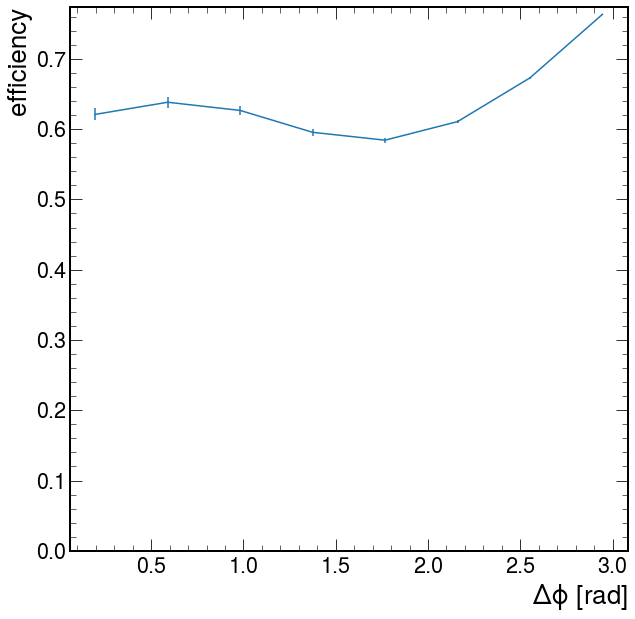

In [108]:
bins=np.linspace(0,np.pi, 9)

q="h1_truth_cm_pt>0.25 and h2_truth_cm_pt>0.25 and h2_truth_p<2.8 and nu_truth>2.3 and nu_truth<4.2 and Q2_truth>1.0 and -Q2_truth+0.9383**2+2*nu_truth*0.9383>2"
q+="and h2_p>0.6"
q_pass=q+" and 1==pass_recon "

ytot,x=np.histogram(df.query(q).dphi_truth, bins=bins)
yacc,x=np.histogram(df.query(q_pass).dphi_truth, bins=bins)

#bincenters=(x[1:]+x[:-1])/2
#plt.errorbar(bincenters, ytot, np.sqrt(ytot))
#plt.errorbar(bincenters, yacc, np.sqrt(yacc))
#plt.show()

efficiencies_1d=yacc/ytot
defficiencies_1d=np.sqrt(yacc*(ytot-yacc)/ytot**3)
plt.errorbar(bincenters, yacc/ytot, np.sqrt(yacc*(ytot-yacc)/ytot**3))
plt.ylim(0)
plt.xlabel("$\Delta\phi$ [rad]")
plt.ylabel("efficiency")
plt.show()


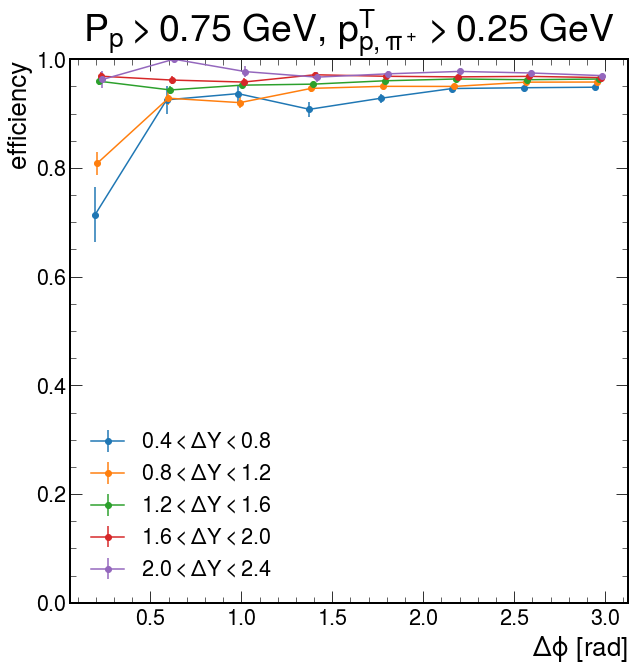

In [185]:
bins=np.linspace(0,np.pi, 9)

q="h1_p>0 and e_p>0 and h1_truth_cm_pt>0.25 and h2_truth_cm_pt>0.25 and h2_truth_p<2.8 and nu_truth>2.3 and nu_truth<4.2 and Q2_truth>1.0 and -Q2_truth+0.9383**2+2*nu_truth*0.9383>2**2"
q+=" and h1_truth_z>0.5"
q+=" and  h2_truth_p>0.4 and h2_truth_pid==2212"
#q+=" and h1_cm_pt>0.35 and h2_p>0.5"
q_pass=q+" and 1==pass_recon and pass_proton_TOF_cut and h2_pid==2212 and abs(h2_truth_p-h2_p)/h2_truth_p<0.3"

dy_bins=np.linspace(0.4, 2.4, 6)

efficiencies_2d=[]
defficiencies_2d=[]
for i in range(len(dy_bins)-1):
    ytot,x=np.histogram(df.query(q + f" and drap_truth>{dy_bins[i]} and drap_truth<{dy_bins[i+1]}").dphi_truth, bins=bins)
    yacc,x=np.histogram(df.query(q_pass + f" and drap_truth>{dy_bins[i]} and drap_truth<{dy_bins[i+1]}").dphi_truth, bins=bins)
    
    bincenters=(x[1:]+x[:-1])/2
    #plt.errorbar(bincenters, ytot, np.sqrt(ytot))
    #plt.errorbar(bincenters, yacc, np.sqrt(yacc))
    #plt.show()
    plt.errorbar(bincenters+i*.01, yacc/ytot, np.sqrt(yacc*(ytot-yacc)/ytot**3), 
                 label=f"${dy_bins[i]:.1f}<\Delta Y<{dy_bins[i+1]:.1f}$",
                marker="o")
    efficiencies_2d.append(yacc/ytot)
    defficiencies_2d.append(np.sqrt(yacc*(ytot-yacc)/ytot**3))
plt.xlabel("$\Delta\phi$ [rad]")
plt.ylabel("efficiency")
plt.ylim(0,1)
plt.legend()
plt.title("$P_p>0.75$ GeV, $p^T_{p,\pi^+}>0.25$ GeV")
plt.savefig("images/efficiency_pion_proton.pdf")
plt.show()

In [184]:
import pickle
with open("pion_proton_efficiencies.pkl", "wb") as f:
    pickle.dump({"eff2d":efficiencies_2d, "deff2d":defficiencies_2d,"eff1d":efficiencies_1d, "deff1d":defficiencies_1d}, f)

/tmp/ipykernel_1079449/2432592891.py:19: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(bincenters+i*.01, yacc/(ytot+(ytot==0)), np.sqrt(yacc*(ytot-yacc)/ytot**3),
/tmp/ipykernel_1079449/2432592891.py:22: RuntimeWarning: invalid value encountered in divide
  efficiencies_2d.append(yacc/ytot)
/tmp/ipykernel_1079449/2432592891.py:23: RuntimeWarning: invalid value encountered in divide
  defficiencies_2d.append(np.sqrt(yacc*(ytot-yacc)/ytot**3))
/tmp/ipykernel_1079449/2432592891.py:19: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(bincenters+i*.01, yacc/(ytot+(ytot==0)), np.sqrt(yacc*(ytot-yacc)/ytot**3),
/tmp/ipykernel_1079449/2432592891.py:22: RuntimeWarning: invalid value encountered in divide
  efficiencies_2d.append(yacc/ytot)
/tmp/ipykernel_1079449/2432592891.py:23: RuntimeWarning: invalid value encountered in divide
  defficiencies_2d.append(np.sqrt(yacc*(ytot-yacc)/ytot**3))
/tmp/ipykernel_1079449/2432592891.py:19: RuntimeWarning: invalid v

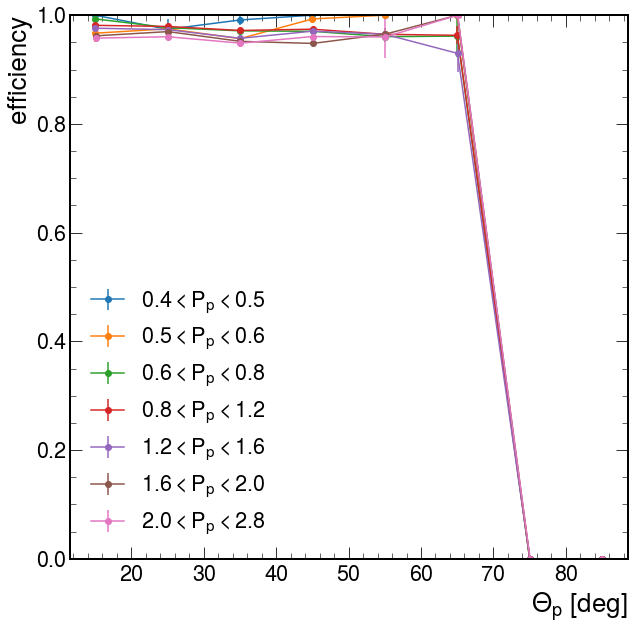

In [186]:
bins=np.linspace(10,90, 9)
#q="h1_p>0 and e_p>0"
#q+=" and  h2_truth_p>0.3"
q+=" and h1_cm_pt>0.25 and h1_z>0.5 and h2_truth_pid==2212"
q_pass=q+" and 1==pass_recon and pass_proton_TOF_cut and h2_pid==2212"

p_bins=(0.4, 0.5, 0.6, 0.8, 1.2, 1.6, 2.0, 2.8)

efficiencies_2d=[]
defficiencies_2d=[]
for i in range(len(p_bins)-1):
    ytot,x=np.histogram(df.query(q + f" and h2_truth_p>{p_bins[i]} and h2_truth_p<{p_bins[i+1]}").h2_th, bins=bins)
    yacc,x=np.histogram(df.query(q_pass + f" and h2_truth_p>{p_bins[i]} and h2_truth_p<{p_bins[i+1]}").h2_th, bins=bins)
    
    bincenters=(x[1:]+x[:-1])/2
    #plt.errorbar(bincenters, ytot, np.sqrt(ytot))
    #plt.errorbar(bincenters, yacc, np.sqrt(yacc))
    #plt.show()
    plt.errorbar(bincenters+i*.01, yacc/(ytot+(ytot==0)), np.sqrt(yacc*(ytot-yacc)/ytot**3), 
                 label=f"${p_bins[i]:.1f}<P_p<{p_bins[i+1]:.1f}$",
                marker="o")
    efficiencies_2d.append(yacc/ytot)
    defficiencies_2d.append(np.sqrt(yacc*(ytot-yacc)/ytot**3))
plt.xlabel("$\Theta_p$ [deg]")
plt.ylabel("efficiency")
plt.ylim(0,1)
plt.legend()
#plt.title("$p^T_{p,\pi^+}>0.25$ GeV")
plt.savefig("images/efficiency_pion_proton_p_theta.pdf")
plt.show()

(array([3.670e+02, 8.790e+02, 1.002e+03, 1.104e+03, 1.314e+03, 1.391e+03,
        1.507e+03, 1.648e+03, 1.751e+03, 1.903e+03, 1.969e+03, 2.072e+03,
        2.244e+03, 2.267e+03, 2.285e+03, 2.545e+03, 2.628e+03, 2.662e+03,
        2.746e+03, 2.911e+03, 2.884e+03, 2.923e+03, 2.917e+03, 2.997e+03,
        3.034e+03, 2.977e+03, 2.987e+03, 3.051e+03, 2.988e+03, 3.051e+03,
        2.907e+03, 2.788e+03, 2.773e+03, 2.720e+03, 2.758e+03, 2.583e+03,
        2.522e+03, 2.455e+03, 2.373e+03, 2.155e+03, 2.033e+03, 1.797e+03,
        1.691e+03, 1.573e+03, 1.420e+03, 1.453e+03, 1.485e+03, 1.509e+03,
        1.515e+03, 1.607e+03, 1.358e+03, 1.367e+03, 1.271e+03, 1.194e+03,
        1.093e+03, 1.064e+03, 9.810e+02, 8.370e+02, 8.060e+02, 7.560e+02,
        6.820e+02, 6.690e+02, 6.080e+02, 5.750e+02, 4.980e+02, 4.920e+02,
        4.610e+02, 3.700e+02, 3.290e+02, 3.010e+02, 2.470e+02, 2.380e+02,
        2.190e+02, 1.950e+02, 1.720e+02, 1.380e+02, 1.010e+02, 1.290e+02,
        9.900e+01, 7.200e+01, 7.100e+0

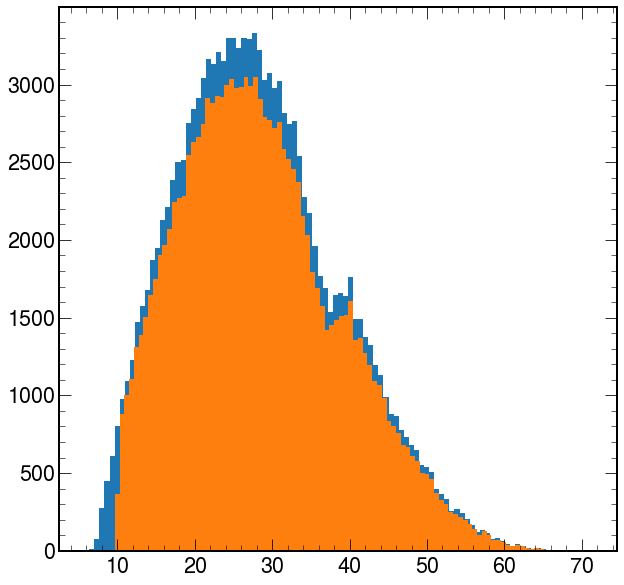

In [187]:
q="h1_p>0 and e_p>0 and h1_truth_cm_pt>0.25 and h2_truth_cm_pt>0.25 and h2_truth_p<2.8 and nu_truth>2.3 and nu_truth<4.2 and Q2_truth>1.0 and -Q2_truth+0.9383**2+2*nu_truth*0.9383>4"
q+=" and h1_z>0.5"
#q+=" and  h2_truth_p>0.5"
#q+=" and h2_truth_pid==2212"
q+=" and h2_truth_pid==2212"
#q+=" and h1_cm_pt>0.35 and h2_p>0.5"
q_pass=q+" and 1==pass_recon and pass_proton_TOF_cut and h2_pid==2212"

plt.hist(df.query(q).h2_truth_th, bins=100)
plt.hist(df.query(q_pass).h2_truth_th, bins=100)


In [178]:
q="h1_p>0 and e_p>0 and h1_truth_cm_pt>0.25 and h2_truth_cm_pt>0.25 and h2_truth_p<2.8 and nu_truth>2.3 and nu_truth<4.2 and Q2_truth>1.0 and -Q2_truth+0.9383**2+2*nu_truth*0.9383>2"
print(set(df.query(q).h2_truth_pid))

{321, 211, 2212, -211}


/tmp/ipykernel_1079449/953493396.py:21: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(bincenters+i*.01, yacc/(ytot+(ytot==0)), np.sqrt(yacc*(ytot-yacc)/ytot**3),
/tmp/ipykernel_1079449/953493396.py:24: RuntimeWarning: invalid value encountered in divide
  efficiencies_2d.append(yacc/ytot)
/tmp/ipykernel_1079449/953493396.py:25: RuntimeWarning: invalid value encountered in divide
  defficiencies_2d.append(np.sqrt(yacc*(ytot-yacc)/ytot**3))
/tmp/ipykernel_1079449/953493396.py:21: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(bincenters+i*.01, yacc/(ytot+(ytot==0)), np.sqrt(yacc*(ytot-yacc)/ytot**3),
/tmp/ipykernel_1079449/953493396.py:24: RuntimeWarning: invalid value encountered in divide
  efficiencies_2d.append(yacc/ytot)
/tmp/ipykernel_1079449/953493396.py:25: RuntimeWarning: invalid value encountered in divide
  defficiencies_2d.append(np.sqrt(yacc*(ytot-yacc)/ytot**3))
/tmp/ipykernel_1079449/953493396.py:21: RuntimeWarning: invalid value en

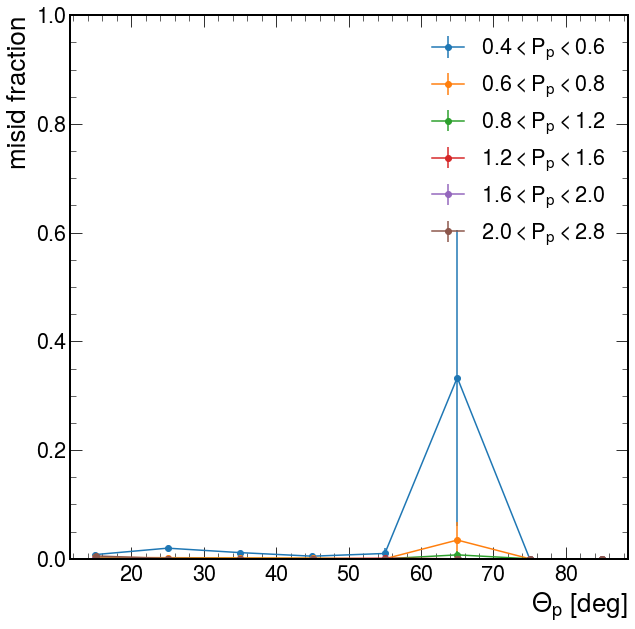

In [195]:
#now check the purity of the sample

bins=np.linspace(10,90, 9)
q="h1_p>0 and e_p>0"
#q+=" and  h2_truth_p>0.3"
q+=" and h1_cm_pt>0.25 and h1_z>0.5 and pass_proton_TOF_cut and h2_pid==2212"
q_pass=q+" and h2_truth_pid!=2212 "

p_bins=(0.4, 0.6, 0.8, 1.2, 1.6, 2.0, 2.8)

efficiencies_2d=[]
defficiencies_2d=[]
for i in range(len(p_bins)-1):
    ytot,x=np.histogram(df.query(q + f" and h2_truth_p>{p_bins[i]} and h2_truth_p<{p_bins[i+1]}").h2_th, bins=bins)
    yacc,x=np.histogram(df.query(q_pass + f" and h2_truth_p>{p_bins[i]} and h2_truth_p<{p_bins[i+1]}").h2_th, bins=bins)
    
    bincenters=(x[1:]+x[:-1])/2
    #plt.errorbar(bincenters, ytot, np.sqrt(ytot))
    #plt.errorbar(bincenters, yacc, np.sqrt(yacc))
    #plt.show()
    plt.errorbar(bincenters+i*.01, yacc/(ytot+(ytot==0)), np.sqrt(yacc*(ytot-yacc)/ytot**3), 
                 label=f"${p_bins[i]:.1f}<P_p<{p_bins[i+1]:.1f}$",
                marker="o")
    efficiencies_2d.append(yacc/ytot)
    defficiencies_2d.append(np.sqrt(yacc*(ytot-yacc)/ytot**3))
plt.xlabel("$\Theta_p$ [deg]")
plt.ylabel("misid fraction")
plt.ylim(0,1)
plt.legend()
#plt.title("$p^T_{p,\pi^+}>0.25$ GeV")
plt.savefig("images/misid_pion_proton_p_theta.pdf")
plt.show()

In [193]:
q+=" and h1_cm_pt>0.25 and h1_z>0.5 and pass_proton_TOF_cut and h2_pid==2212"
q_misid=q+" and h2_truth_pid!=2212 "
len(df.query(q_misid))/len(df.query(q))

0.08516048430064856

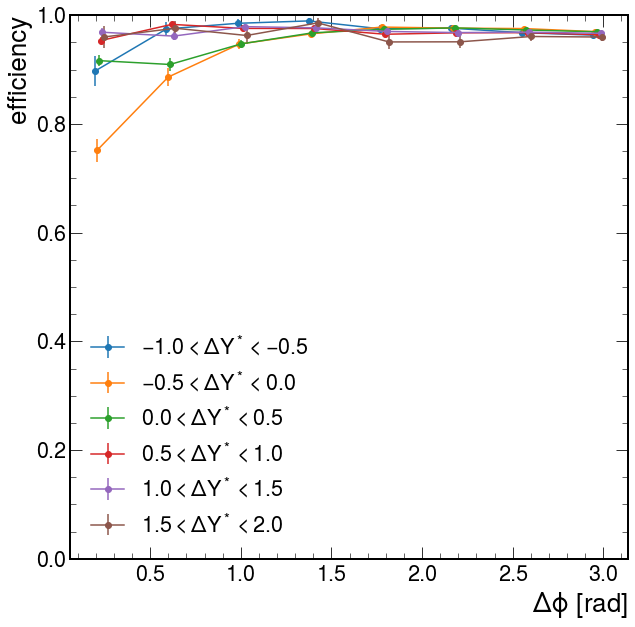

In [10]:
#First look at the efficiency of detecting a single particle

q_denom="h1_p>0 and e_p>0 and h1_pid==211 and h1_truth_pid==211 and h1_FidCutPiPlus and nu>2.3 and nu<4.2 and Q2>1 "
q_denom+=" and h1_cm_pt>0.07 and h2_truth_cm_pt>0.07 and h1_z>0.5 and h2_truth_pid==2212 and h2_truth_p>0.2 and h2_truth_p<2.8 and h2_truth_th>10"
#q_denom+= " and abs(h1_p-h1_truth_p)/h1_truth_p<0.3"
q_denom+= " and " + trigger_cut_nom
q_num=q_denom+" and pass_proton_TOF_cut and h2_pid==2212 and h2_FidCutPiPlus"
q_num+=" and " + pair_cut_nom_pi_p 

efficiencies_2d, defficiencies_2d = ratio_plot(q_num, q_denom, ylabel="efficiency", 
                                               slice_var="drap_truth-ycm_truth", xvar="dphi_truth",
                                              slice_bins=np.linspace(-1.0, 2.0,7), 
                                              xbins=np.linspace(0, np.pi, 9))
#plt.title("$p^T_{p,\pi^+}>0.25$ GeV")
plt.savefig(f"images/efficiency_proton_extended_dY.pdf")
plt.show()



In [1]:
#now check the purity of the sample
ptmin=0.071
for misid_particle in "proton", "pion":

    q_denom="h1_p>0 and e_p>0 and h1_pid==211"
    q_denom+=f" and h1_cm_pt>{ptmin} and h2_cm_pt>{ptmin} and h1_z>0.5 and pass_proton_TOF_cut and h2_pid==2212 and h2_p>0.4 and h2_p<2.8 and h2_truth_th>10"
    q_denom+=" and h2_FidCutPiPlus and h1_FidCutPiPlus and h1_truth_pid!=-9999 and h2_truth_pid!=-9999"
    q_denom+= " and " + trigger_cut_nom
    q_denom+=" and " + pair_cut_nom_pi_p 
    if misid_particle =="proton":
        q_num=q_denom+" and (h2_truth_pid!=2212)"
    else :
        q_num=q_denom+" and (h1_truth_pid!=211)"
    
    ratio_plot(q_num, q_denom, ylabel=misid_particle+" misid fraction",
                                              slice_bins=np.linspace(-1.0, 2.0,7), 
                                              xbins=np.linspace(0, np.pi, 9))
    #plt.title("$p^T_{p,\pi^+}>0.25$ GeV")
    plt.ylim(0,.25)
    #plt.savefig(f"images/misid_{misid_particle}.pdf")
    plt.show()

NameError: name 'trigger_cut_nom' is not defined

In [40]:
print(q)

h1_p>0 and e_p>0 and h1_pid==211 and h1_cm_pt>0.071 and h2_cm_pt>0.071 and h1_z>0.5 and pass_proton_TOF_cut and h2_pid==2212 and h2_p>0.2 and h2_p<2.8 and h2_truth_th>10 and h2_FidCutPiPlus and h1_FidCutPiPlus and h1_truth_pid!=-9999 and h2_truth_pid!=-9999 and h2_truth_p>0


['dphi',
 'dphi_lab',
 'drap',
 'h1_z',
 'h2_z',
 'h1_cm_pt',
 'h2_cm_pt',
 'h1_xf',
 'h2_xf',
 'h1_rap',
 'ycm',
 'h2_rap',
 'h1_pid',
 'h2_pid',
 'h1_cm_ph',
 'h2_cm_ph',
 'h1_cm_th',
 'h2_cm_th',
 'pair_mass',
 'pair_pt',
 'mx_eh1h2x',
 'mx_eh1x',
 'mx_eh2x',
 't',
 'Q2',
 'nu',
 'W',
 'e_px',
 'e_py',
 'e_pz',
 'e_p',
 'e_ph',
 'e_th',
 'SampFracEl25',
 'SampFracEl20',
 'TargTypeSM',
 'TargType',
 'x',
 'u',
 'h1_ph',
 'h1_th',
 'h2_ph',
 'h2_th',
 'h1_p',
 'h2_p',
 'h1_deltaZ',
 'h2_deltaZ',
 'h1_Nphe',
 'h2_Nphe',
 'h1_Sector',
 'h2_Sector',
 'h1_FidCut',
 'h2_FidCut',
 'h1_FidCutPiPlus',
 'h2_FidCutPiPlus',
 'h1_Chi2CC',
 'h2_Chi2CC',
 'h1_StatCC',
 'h2_StatCC',
 'h1_Betta',
 'h2_Betta',
 'h1_T4',
 'h2_T4',
 'evnt',
 'pass_recon',
 'dphi_truth',
 'dphi_lab_truth',
 'drap_truth',
 'h1_truth_z',
 'h2_truth_z',
 'h1_truth_cm_pt',
 'h2_truth_cm_pt',
 'h1_truth_xf',
 'h2_truth_xf',
 'h1_truth_rap',
 'ycm_truth',
 'h2_truth_rap',
 'h1_truth_pid',
 'h2_truth_pid',
 'h1_truth_p',
 'h2_t

In [568]:
import ROOT

Welcome to JupyROOT 6.27/01


(array([3.6000e+01, 1.2800e+02, 5.6400e+02, 1.2920e+03, 2.6800e+03,
        4.3530e+03, 6.3920e+03, 8.7270e+03, 1.1288e+04, 1.3658e+04,
        1.5869e+04, 1.8054e+04, 1.9996e+04, 2.2076e+04, 2.3546e+04,
        2.4476e+04, 2.5321e+04, 2.5611e+04, 2.5403e+04, 2.5687e+04,
        2.4893e+04, 2.4460e+04, 2.4028e+04, 2.3006e+04, 2.1954e+04,
        2.0712e+04, 1.9597e+04, 1.8505e+04, 1.7220e+04, 1.6290e+04,
        1.5102e+04, 1.4014e+04, 1.3005e+04, 1.1888e+04, 1.1022e+04,
        1.0075e+04, 9.2580e+03, 8.3550e+03, 7.6290e+03, 6.7470e+03,
        5.9860e+03, 5.3860e+03, 4.8240e+03, 4.1380e+03, 3.5650e+03,
        3.1790e+03, 2.7670e+03, 2.2640e+03, 1.8920e+03, 1.5790e+03,
        1.2300e+03, 1.0810e+03, 8.2700e+02, 6.3600e+02, 5.2800e+02,
        3.4100e+02, 2.7000e+02, 2.1100e+02, 1.3400e+02, 1.0200e+02,
        4.9000e+01, 3.4000e+01, 3.4000e+01, 2.1000e+01, 1.1000e+01,
        1.3000e+01, 1.0000e+01, 7.0000e+00, 4.0000e+00, 5.0000e+00,
        7.0000e+00, 3.0000e+00, 5.0000e+00, 0.00

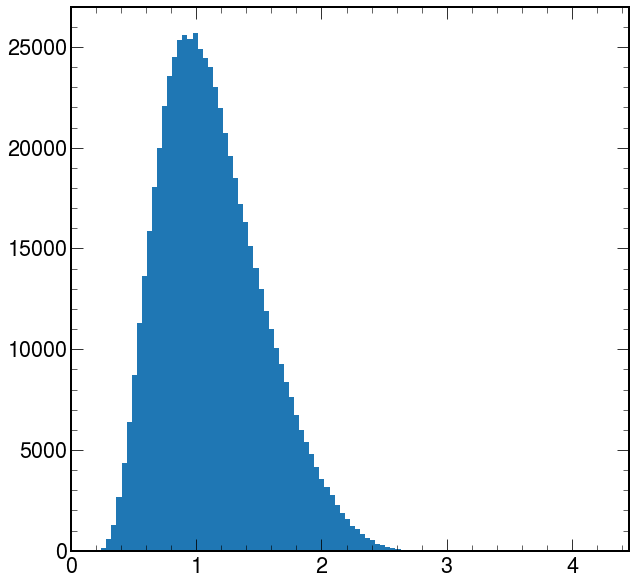

In [574]:
plt.hist(dfs_pair['Pb'].query("h2_p>0").h2_truth_p, bins=100)

In [99]:
for df in dfs_pair.values():
    dphi=df.eval('h1_truth_cm_ph-h2_truth_cm_ph')
    df['signdphi_truth']=np.sign(dphi+(dphi>np.pi)*(-2*np.pi)+(dphi<-np.pi)*(2*np.pi))

/tmp/ipykernel_642642/1989433447.py:25: RuntimeWarning: invalid value encountered in sqrt
  dri=ri/((n_uw+(n_uw==0))/(d_uw+(d_uw==0)))*np.sqrt((n_uw+(n_uw==0))*(d_uw-n_uw+(d_uw-n_uw==0))/(d_uw+(d_uw==0))**3)
/home/sebouh/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/tmp/ipykernel_642642/1989433447.py:25: RuntimeWarning: invalid value encountered in sqrt
  dri=ri/((n_uw+(n_uw==0))/(d_uw+(d_uw==0)))*np.sqrt((n_uw+(n_uw==0))*(d_uw-n_uw+(d_uw-n_uw==0))/(d_uw+(d_uw==0))**3)
/home/sebouh/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/tmp/ipykernel_642642/1989433447.py:25: RuntimeWarning: invalid value encountered in sqrt
  dri=ri/((n_uw+(n_uw==0))/(d_uw+(d_uw==0)))*np.sqrt((n_uw+(n_uw==0))*(d_uw-n_uw+(d_uw-n_uw==0))/(d_uw+(d_uw==0))**3)
/home/sebouh/.local/lib/python3.8/site-packages/matplo

target= D variation= 0.1061720573849968
(max-min)/(max+min)*2= 0.30121492719090454


/tmp/ipykernel_642642/1989433447.py:25: RuntimeWarning: invalid value encountered in sqrt
  dri=ri/((n_uw+(n_uw==0))/(d_uw+(d_uw==0)))*np.sqrt((n_uw+(n_uw==0))*(d_uw-n_uw+(d_uw-n_uw==0))/(d_uw+(d_uw==0))**3)
/home/sebouh/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/tmp/ipykernel_642642/1989433447.py:25: RuntimeWarning: invalid value encountered in sqrt
  dri=ri/((n_uw+(n_uw==0))/(d_uw+(d_uw==0)))*np.sqrt((n_uw+(n_uw==0))*(d_uw-n_uw+(d_uw-n_uw==0))/(d_uw+(d_uw==0))**3)
/home/sebouh/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/tmp/ipykernel_642642/1989433447.py:25: RuntimeWarning: invalid value encountered in sqrt
  dri=ri/((n_uw+(n_uw==0))/(d_uw+(d_uw==0)))*np.sqrt((n_uw+(n_uw==0))*(d_uw-n_uw+(d_uw-n_uw==0))/(d_uw+(d_uw==0))**3)
/home/sebouh/.local/lib/python3.8/site-packages/matplo

target= D variation= 0.10586413660315168
(max-min)/(max+min)*2= 0.25058812924582824


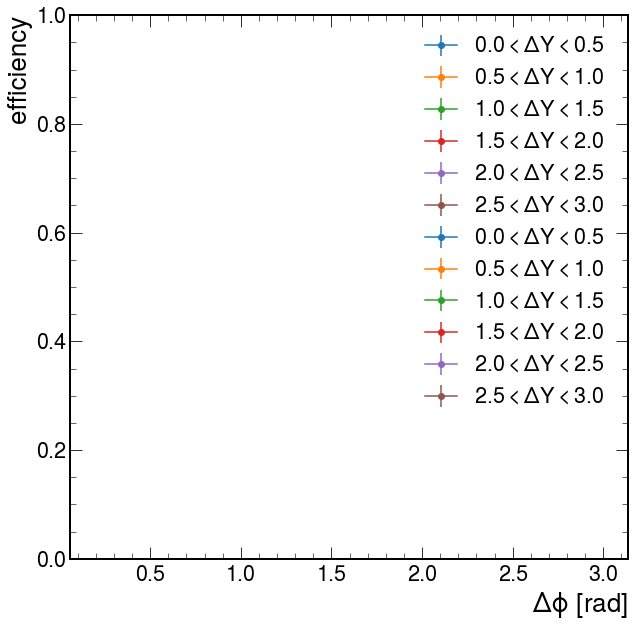

In [100]:
q_denom="h1_p>0"
q_denom+=" and e_p>0"
q_denom+= " and h1_pid==211 and h1_truth_pid==211 and nu>2.3 and nu<4.2 and Q2>1 "
q_denom+=" and h1_FidCutPiPlus == 1"
q_denom+=" and h1_cm_pt>0.07 and h2_truth_cm_pt>0.07 and h1_z>0.5 and h2_truth_pid==2212 and h2_truth_p>0.35 and h2_truth_p<2.8 and h2_truth_th>10"

q_denom+= " and " + trigger_cut_nom
q_num=q_denom

q_num+=" and pass_proton_TOF_cut "
q_num+=" and h2_pid==2212"
q_num+=" and h2_FidCutPiPlus == 1"
q_num+=" and " + pair_cut_nom_pi_p 

efficiencies_2d, defficiencies_2d={},{}
for pm in "><":
    target="D"
    eff,deff = ratio_plot(q_num, q_denom+f" and signdphi_truth{pm}0", dfs_pair[target],  
                                                                   ylabel="efficiency", slice_var="drap_truth",
                                                   slice_bins=(0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0),xvar="dphi_truth")
    efficiencies_2d[pm]=eff
    defficiencies_2d[pm]=deff
    import awkward as ak
    vals=ak.flatten(efficiencies_2d[pm])
    print("target=",target,"variation=",np.std(vals)/np.mean(vals))
    print("(max-min)/(max+min)*2=", (np.max(vals)-np.min(vals))/(np.max(vals)+np.min(vals)))
    